Welcome to my notebook on Machine learning with Pyspark, this notebook goes over some fudnamentals of machine learning in pyspark a great tool for handling big data and models

In [2]:
!pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/Machine Learning with Pyspark'
os.chdir(path)

In [5]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, round, to_date
import seaborn as sns
import matplotlib.pyplot as plt



In [6]:
spark = SparkSession.builder \
    .appName("MySparkSession") \
    .getOrCreate()

In [7]:
# Return spark version
print(spark.version)

# Return python version
import sys
print(sys.version_info)

3.5.3
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [8]:
# when reading in data you can choose whether to inferSchema or not,
# if you do numeric values may still be incorrectly typed this also takes longer as the spark mudt read the data twice

# Read data from CSV file
flights = spark.read.csv('flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)

The data contain 50000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| NULL|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| NULL|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [9]:
# Check column data types
print(flights.dtypes)

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


In [10]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# Load data from a delimited file
sms = spark.read.csv('sms.csv', sep=';', header=False, schema=schema)

# Print schema of DataFrame
sms.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [11]:
# before modeling it is good to clean an understand data
# Remove the 'flight' column
flights1 = flights.drop("flight")

# Number of records with missing 'delay' values
flights1.filter('delay IS NULL').count()

2978

In [12]:
# Remove records with missing 'delay' values

flights1 = flights1.filter("delay IS NOT NULL")

In [13]:
flights.count()

50000

In [14]:
# Remove records with missing values in any column and get the number of remaining rows
flights1 = flights1.dropna()
print(flights1.count())

47022


In [15]:
# for feature engineering it also makes sense to convert metrics we can use for more insights

from pyspark.sql.functions import round


# Convert 'mile' to 'km' and drop 'mile' column (1 mile is equivalent to 1.60934 km)
flights1 = flights1.withColumn('km', round(flights['mile'] * 1.60934, 0)) \
                    .drop('mile')

when predicting we need to use explicit data for working with labelled data.

we are looking for whether a flight is delayed or not and will use 15 minutes past the expected time to indicate this

In [16]:
# Create 'label' column indicating whether flight delayed (1) or not (0)
flights1 = flights1.withColumn('label', (flights1['delay']>=15).cast('integer'))
# if longer than 15 minutes this is a delay
# Check first five records
flights1.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



Now we have our labels we need to make the data ready for modelling, strings must be indexed and converted to numbers as models only work with numerical values. However due to the indexing weights can be applied to numbers. This is where one hot encoding comes in which makes the data format wide and allows for boolean columns of 1 0 which removes the need for weighting.

In [17]:
# string indexers allow you to create an index of every unique string in a column
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(flights1)

# Indexer creates a new column with numeric index values
flights1 = indexer_model.transform(flights1)

# Repeat the process for the other categorical feature - note this can be done on one line
flights1 = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights1).transform(flights1)
flights1.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|        0.0|    0.0|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|        0.0|    1.0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|        1.0|    0.0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|        0.0|    1.0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|        1.0|    0.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
only showing top 5 rows



once the numeric features are assembled you can use a vector assembler to assemble into one feature for the model to work on

In [18]:
# vector assemblers create an object ready for modeling as this is required to feed into the mdoel
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=['mon','dom','dow', 'carrier_idx', 'org_idx','km','depart','duration'], outputCol='features')

# Consolidate predictor columns
flights1_assembled = assembler.transform(flights1)
# Check the resulting column
flights1_assembled.select('features', 'delay').show(5, truncate=False)


+-----------------------------------------+-----+
|features                                 |delay|
+-----------------------------------------+-----+
|[0.0,22.0,2.0,0.0,0.0,509.0,16.33,82.0]  |30   |
|[2.0,20.0,4.0,0.0,1.0,542.0,6.17,82.0]   |-8   |
|[9.0,13.0,1.0,1.0,0.0,1989.0,10.33,195.0]|-5   |
|[5.0,2.0,1.0,0.0,1.0,885.0,7.98,102.0]   |2    |
|[7.0,2.0,6.0,1.0,0.0,1180.0,10.83,135.0] |54   |
+-----------------------------------------+-----+
only showing top 5 rows



In [19]:
# to see how well our mdoel performs we must split the data note typically you do this before any transformation
# Split into training and testing sets in a 80:20 ratio
flights1_train, flights1_test = flights1_assembled.randomSplit([0.8,0.2], seed=43)
# Check that training set has around 80% of records
training_ratio = flights1_train.count() / flights.count()
print(training_ratio)

0.75474


In [20]:
# the first model we will use is a decision tree
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
flights1_tree_model = tree.fit(flights1_train)

In [21]:
# Create predictions for the testing data and take a look at the predictions
flights1_tree_prediction = flights1_tree_model.transform(flights1_test)
flights1_tree_prediction.select('label', 'prediction', 'probability').show(5, False)



+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|1    |1.0       |[0.4972549019607843,0.5027450980392156]|
|1    |1.0       |[0.4972549019607843,0.5027450980392156]|
|0    |1.0       |[0.3853515375781549,0.6146484624218451]|
|1    |1.0       |[0.3853515375781549,0.6146484624218451]|
|1    |1.0       |[0.3853515375781549,0.6146484624218451]|
+-----+----------+---------------------------------------+
only showing top 5 rows



In [22]:
# Create a confusion matrix
flights1_tree_prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1079|
|    0|       0.0| 2234|
|    1|       1.0| 3684|
|    0|       1.0| 2288|
+-----+----------+-----+



In [23]:
# Calculate the elements of the confusion matrix
TN = flights1_tree_prediction.filter('prediction = 0 AND label = prediction').count()
TP = flights1_tree_prediction.filter('prediction = 1 AND label = prediction').count()
FN = flights1_tree_prediction.filter('prediction = 0 AND label != prediction').count()
FP = flights1_tree_prediction.filter('prediction = 1 AND label != prediction').count()

Definition: Accuracy is the ratio of correctly predicted observations to the total observations.

Definition: Precision, also called the positive predictive value, is the ratio of correctly predicted positive observations to the total predicted positive observations.

Definition: Recall, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to all observations in the actual class.

In [24]:
# Accuracy measures the proportion of correct predictions
flights1_tree_accuracy = (TP+TN)/(TP+TN+FN+FP)
flights1_tree_precision = TP/ (TP+FP)

flights1_tree_recall  = TP/(TP+FN)
print(flights1_tree_accuracy)
print(flights1_tree_precision)
print(flights1_tree_recall)

0.6373721055465805
0.6168787675820495
0.7734621037161453


In [25]:
# Import the logistic regression class
from pyspark.ml.classification import LogisticRegression

# Create a classifier object and train on training data
flights1_logistic = LogisticRegression().fit(flights1_train)

# Create predictions for the testing data and show confusion matrix
flights1_logistic_prediction = flights1_logistic.transform(flights1_test)
flights1_logistic_prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1705|
|    0|       0.0| 2561|
|    1|       1.0| 3058|
|    0|       1.0| 1961|
+-----+----------+-----+



In [26]:
# Calculate the elements of the confusion matrix
TN = flights1_logistic_prediction.filter('prediction = 0 AND label = prediction').count()
TP = flights1_logistic_prediction.filter('prediction = 1 AND label = prediction').count()
FN = flights1_logistic_prediction.filter('prediction = 0 AND label != prediction').count()
FP = flights1_logistic_prediction.filter('prediction = 1 AND label != prediction').count()
# Accuracy measures the proportion of correct predictions
flights1_logistic_accuracy = (TP+TN)/(TP+TN+FN+FP)
flights1_logistic_precision = TP/ (TP+FP)

flights1_logistic_recall  = TP/(TP+FN)
print(flights1_logistic_accuracy)
print(flights1_logistic_precision)
print(flights1_logistic_recall)

0.6051696284329564
0.609284718071329
0.6420323325635104


there's also evaluators you can import to do this on your behalf

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

precision = 0.61
recall    = 0.64


Weighted precision is a metric used in classification tasks, particularly when dealing with multiclass or imbalanced datasets where some classes may appear much more frequently than others. It calculates the precision (the ratio of true positive predictions to the total predicted positives) for each class individually and then takes a weighted average of these precision scores, using each class's proportion in the dataset as the weight.

In [28]:
# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(flights1_logistic_prediction, {multi_evaluator.metricName: "weightedPrecision"})

The AUC score can be interpreted as the probability that the model will correctly rank a randomly chosen positive instance higher than a randomly chosen negative instance.

In [29]:
# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(flights1_logistic_prediction, {binary_evaluator.metricName: "areaUnderROC"})


In [30]:
print(weighted_precision)
print(auc)

0.6049226844696598
0.6416634313426791


#SMS walkthrough 1

when working with text you can turn it into tokens when doing this you want to remove frequent words

In [31]:
# Import the necessary functions
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

# Remove punctuation (REGEX provided) and numbers
sms1 = sms.withColumn('text', regexp_replace(sms.text, '[_():;,.!?\\-]', ' '))
sms1 = sms1.withColumn('text', regexp_replace(sms1.text, '[0-9]', ' '))
# Merge multiple spaces
sms1 = sms1.withColumn('text', regexp_replace(sms1.text, ' +', ' '))

# Split the text into words
sms1 = Tokenizer(inputCol='text', outputCol='words').transform(sms1)

sms1.show(4, truncate=False)

+---+----------------------------------+-----+------------------------------------------+
|id |text                              |label|words                                     |
+---+----------------------------------+-----+------------------------------------------+
|1  |Sorry I'll call later in meeting  |0    |[sorry, i'll, call, later, in, meeting]   |
|2  |Dont worry I guess he's busy      |0    |[dont, worry, i, guess, he's, busy]       |
|3  |Call FREEPHONE now                |1    |[call, freephone, now]                    |
|4  |Win a cash prize or a prize worth |1    |[win, a, cash, prize, or, a, prize, worth]|
+---+----------------------------------+-----+------------------------------------------+
only showing top 4 rows



words that appear often are called stop words you can remove these to make the modelling easier and better able to focus on relevant wordings as mentioned the models need numeric values so to overcome this we can hash words to make them into numerical values

TF-IDF is also applied Term Frequency inverse Document frequency, it is used to extract significant words and phrases to understnd text exerts

In [32]:
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF


# Remove stop words.
sms1 = StopWordsRemover(inputCol='words', outputCol='terms').transform(sms1)

# Apply the hashing trick
sms1 = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024)\
      .transform(sms1)

# Convert hashed symbols to TF-IDF
sms1 = IDF(inputCol='hash', outputCol='features')\
      .fit(sms1).transform(sms1)

sms1.select('terms', 'features').show(4, truncate=False)

+--------------------------------+----------------------------------------------------------------------------------------------------+
|terms                           |features                                                                                            |
+--------------------------------+----------------------------------------------------------------------------------------------------+
|[sorry, call, later, meeting]   |(1024,[138,384,577,996],[2.273418200008753,3.6288353225642043,3.5890949939146903,4.104259019279279])|
|[dont, worry, guess, busy]      |(1024,[215,233,276,329],[3.9913186080986836,3.3790235241678332,4.734227298217693,4.58299632849377]) |
|[call, freephone]               |(1024,[133,138],[5.367951058306837,2.273418200008753])                                              |
|[win, cash, prize, prize, worth]|(1024,[31,47,62,389],[3.6632029660684124,4.754846585420428,4.072170704727778,7.064594791043114])    |
+--------------------------------+--------------

In [33]:
# Split the data into training and testing sets
sms1_train, sms1_test = sms1.randomSplit([0.8,0.2], seed=13)

In [34]:
# Fit a Logistic Regression model to the training data
sms1_logistic = LogisticRegression(regParam=0.2).fit(sms1_train)
# Make predictions on the testing data
sms1_logistic_prediction = sms1_logistic.transform(sms1_test)

# Create a confusion matrix, comparing predictions to known labels
sms1_logistic_prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   41|
|    0|       0.0|  948|
|    1|       1.0|  105|
|    0|       1.0|    2|
+-----+----------+-----+



In [35]:
# Calculate the elements of the confusion matrix
TN = sms1_logistic_prediction.filter('prediction = 0 AND label = prediction').count()
TP = sms1_logistic_prediction.filter('prediction = 1 AND label = prediction').count()
FN = sms1_logistic_prediction.filter('prediction = 0 AND label != prediction').count()
FP = sms1_logistic_prediction.filter('prediction = 1 AND label != prediction').count()
# Accuracy measures the proportion of correct predictions
sms1_logistic_accuracy = (TP+TN)/(TP+TN+FN+FP)
sms1_logistic_precision = TP/ (TP+FP)

sms1_logistic_recall  = TP/(TP+FN)
print(sms1_logistic_accuracy)
print(sms1_logistic_precision)
print(sms1_logistic_recall)

0.9607664233576643
0.9813084112149533
0.7191780821917808


# flights with Bucketing

To make models more accurate you can convert continuous variables into discrete by bucketing.
Bucketing is when you put ranges of variables into buckets to aid the machine learning model

In [36]:
# returning to original flights
flights2 = flights

flights2 = flights2.drop("flight")

# Number of records with missing 'delay' values
flights2.filter('delay IS NULL').count()
flights2 = flights2.filter("delay IS NOT NULL")

# Convert 'mile' to 'km' and drop 'mile' column (1 mile is equivalent to 1.60934 km)
flights2 = flights2.withColumn('km', round(flights2['mile'] * 1.60934, 0)).drop('mile')
# Create 'label' column indicating whether flight delayed (1) or not (0)
flights2 = flights2.withColumn('label', (flights2['delay']>=15).cast('integer'))
# if longer than 15 minutes this is a delay
# Check first five records
flights2.show(5)


+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



In [37]:
from pyspark.ml.feature import Bucketizer, OneHotEncoder


# Create buckets at 3 hour intervals through the day
depart_buckets = Bucketizer(splits=[0, 3, 6, 9, 12, 15, 18, 21, 24], inputCol='depart', outputCol='depart_bucket')

# Bucket the departure times
flights2 = depart_buckets.transform(flights2)
flights2.select('depart', 'depart_bucket').show(5)

+------+-------------+
|depart|depart_bucket|
+------+-------------+
| 16.33|          5.0|
|  6.17|          2.0|
| 10.33|          3.0|
|  7.98|          2.0|
| 10.83|          3.0|
+------+-------------+
only showing top 5 rows



In [38]:
# Create a one-hot encoder
flights_onehot = OneHotEncoder(inputCols=['depart_bucket'], outputCols=['depart_dummy'])

# One-hot encode the bucketed departure times
flights2 = flights_onehot.fit(flights2).transform(flights2)
flights2.select('depart', 'depart_bucket', 'depart_dummy').show(5)

+------+-------------+-------------+
|depart|depart_bucket| depart_dummy|
+------+-------------+-------------+
| 16.33|          5.0|(7,[5],[1.0])|
|  6.17|          2.0|(7,[2],[1.0])|
| 10.33|          3.0|(7,[3],[1.0])|
|  7.98|          2.0|(7,[2],[1.0])|
| 10.83|          3.0|(7,[3],[1.0])|
+------+-------------+-------------+
only showing top 5 rows



In [39]:
flights2.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-------------+-------------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|depart_bucket| depart_dummy|
+---+---+---+-------+---+------+--------+-----+------+-----+-------------+-------------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|          5.0|(7,[5],[1.0])|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|          2.0|(7,[2],[1.0])|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|          3.0|(7,[3],[1.0])|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|          2.0|(7,[2],[1.0])|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|          3.0|(7,[3],[1.0])|
+---+---+---+-------+---+------+--------+-----+------+-----+-------------+-------------+
only showing top 5 rows



In [40]:
flights2_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
flights2_indexer = flights2_indexer.fit(flights2)

# Indexer creates a new column with numeric index values
flights2 = flights2_indexer.transform(flights2)

# Repeat the process for the other categorical feature - note this can be done on one line
flights2 = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights2).transform(flights2)

In [41]:
# Create an assembler object
flights2_assembler = VectorAssembler(inputCols=['mon','dom','dow', 'carrier_idx', 'org_idx','km','depart_dummy','duration'], outputCol='features')

# Consolidate predictor columns
flights2 = flights2_assembler.transform(flights2)

In [42]:
flights2_train, flights2_test = flights2.randomSplit([0.8,0.2], seed=43)
flights2_logistic = LogisticRegression(regParam=0.2).fit(flights2_train)
flights2_logistic_prediction = flights2_logistic.transform(flights2_test)

In [43]:
# Calculate the elements of the confusion matrix
TN = flights2_logistic_prediction.filter('prediction = 0 AND label = prediction').count()
TP = flights2_logistic_prediction.filter('prediction = 1 AND label = prediction').count()
FN = flights2_logistic_prediction.filter('prediction = 0 AND label != prediction').count()
FP = flights2_logistic_prediction.filter('prediction = 1 AND label != prediction').count()
# Accuracy measures the proportion of correct predictions
flights2_logistic_accuracy = (TP+TN)/(TP+TN+FN+FP)
flights2_logistic_precision = TP/ (TP+FP)

flights2_logistic_recall  = TP/(TP+FN)
print(flights2_logistic_accuracy)
print(flights2_logistic_precision)
print(flights2_logistic_recall)

0.5980613893376413
0.5959426763446863
0.6722653789628386


In [44]:
flights2_tree_model = tree.fit(flights2_train)
flights2_tree_prediction = flights2_tree_model.transform(flights2_test)

# Calculate the elements of the confusion matrix
TN = flights2_tree_prediction.filter('prediction = 0 AND label = prediction').count()
TP = flights2_tree_prediction.filter('prediction = 1 AND label = prediction').count()
FN = flights2_tree_prediction.filter('prediction = 0 AND label != prediction').count()
FP = flights2_tree_prediction.filter('prediction = 1 AND label != prediction').count()
# Accuracy measures the proportion of correct predictions
flights2_tree_accuracy = (TP+TN)/(TP+TN+FN+FP)
flights2_tree_precision = TP/ (TP+FP)

flights2_tree_recall  = TP/(TP+FN)
print(flights2_tree_accuracy)
print(flights2_tree_precision)
print(flights2_tree_recall)

0.6320947765212709
0.6122312947842027
0.7713625866050808


Penalised regression is one approach as minimising the number of features used the model is penalised for having too many coefficients

Lasso regression and ridge regression are regression forms that aim to address this: Lassso uses a term proportional to the absolute value of the coefficients whilst rice uses the square of the coefficients both aim to penalise models with too many coefficients. Ridge brings them close to zero whilst Lasso forces them to zero


To make a ridge regression model you give the elasticNetParam=0

ridge = LinearRegression(labelCol=‘column’,elsaticNetParam=0,regParam=0.1)

In [45]:
flights3 = flights.drop("flight").dropna()
flights3 = flights3.withColumn('km', round(flights['mile'] * 1.60934, 0)) \
                    .drop('mile')


# Create an indexer
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')
indexer_model = indexer.fit(flights3)
flights3 = indexer_model.transform(flights3)
flights3 = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights3).transform(flights3)
assembler = VectorAssembler(inputCols=['mon','dom','dow', 'carrier_idx', 'org_idx','km','depart','km'], outputCol='features')
flights3 = assembler.transform(flights3)


flights3.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----------+-------+--------------------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|carrier_idx|org_idx|            features|
+---+---+---+-------+---+------+--------+-----+------+-----------+-------+--------------------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|        0.0|    0.0|[0.0,22.0,2.0,0.0...|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|        0.0|    1.0|[2.0,20.0,4.0,0.0...|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|        1.0|    0.0|[9.0,13.0,1.0,1.0...|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|        0.0|    1.0|[5.0,2.0,1.0,0.0,...|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|        1.0|    0.0|[7.0,2.0,6.0,1.0,...|
+---+---+---+-------+---+------+--------+-----+------+-----------+-------+--------------------+
only showing top 5 rows



In [46]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

flights3_train, flights3_test = flights3.randomSplit([0.8,0.2], seed=43)
# Fit Lasso model (λ = 1, α = 1) to training data
flights3_lasso = LinearRegression(labelCol='duration', regParam=1, elasticNetParam=1).fit(flights3_train)
flights3_linear = LinearRegression(labelCol='duration').fit(flights3_train)

# Calculate the RMSE on testing data
flights3_lasso_prediction = flights3_lasso.transform(flights3_test)
flights3_linear_prediction = flights3_linear.transform(flights3_test)

rmse1 = RegressionEvaluator(labelCol='duration').evaluate(flights3_lasso_prediction)
rmse2 = RegressionEvaluator(labelCol='duration').evaluate(flights3_linear_prediction)

print("The test RMSE on f1 is", rmse1)
print("The test RMSE on f2 is", rmse2)

The test RMSE on f1 is 16.576397780253743
The test RMSE on f2 is 16.315815626310055


In [47]:
# Get coefficients for both models
linear_coefficients = flights3_linear.coefficients
lasso_coefficients = flights3_lasso.coefficients

# Print RMSE for each model
print("Test RMSE for Linear Regression:", rmse2)
print("Test RMSE for Lasso Regression:", rmse1)

# Compare the coefficients
print("\nComparison of Coefficients:")
print("Feature Index | Linear Coefficient | Lasso Coefficient")

# Loop through each feature index to print the coefficients
for i in range(len(linear_coefficients)):
    print(f"{i:13} | {float(linear_coefficients[i]):17.6f} | {float(lasso_coefficients[i]):15.6f}")


Test RMSE for Linear Regression: 16.315815626310055
Test RMSE for Lasso Regression: 16.576397780253743

Comparison of Coefficients:
Feature Index | Linear Coefficient | Lasso Coefficient
            0 |          0.077787 |        0.000000
            1 |          0.034662 |        0.000000
            2 |         -0.048240 |        0.000000
            3 |          2.269532 |        1.199630
            4 |         -2.046210 |       -1.064444
            5 |          0.038080 |        0.037483
            6 |          0.156451 |        0.000000
            7 |          0.038080 |        0.037483


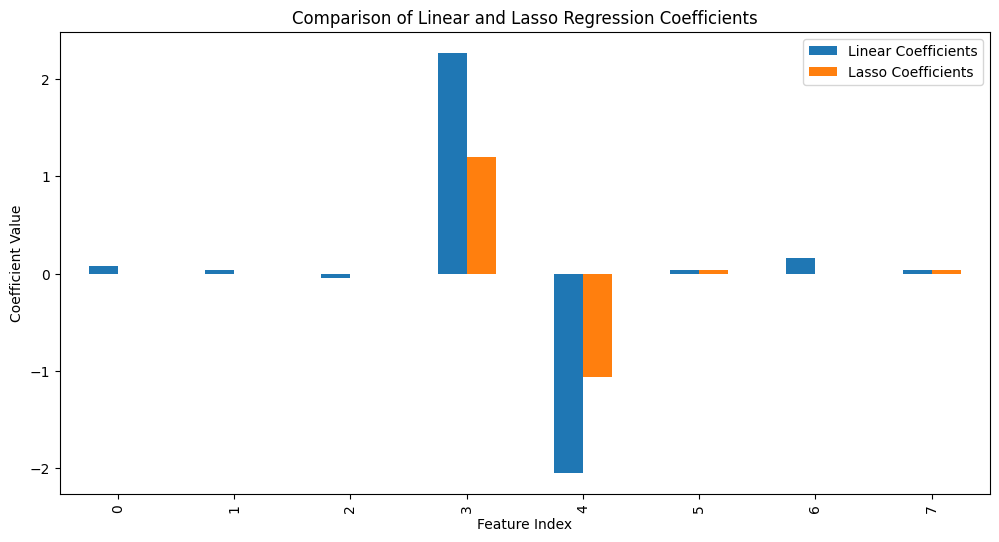

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for comparison
coef_df = pd.DataFrame({
    "Feature Index": range(len(linear_coefficients)),
    "Linear Coefficients": [float(c) for c in linear_coefficients],
    "Lasso Coefficients": [float(c) for c in lasso_coefficients]
})

# Plot the coefficients
coef_df.plot(x="Feature Index", kind="bar", figsize=(12, 6))
plt.title("Comparison of Linear and Lasso Regression Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.show()


Next we will look at decision tree models vs random forestmodels.

A decision tree is a standalone model that makes decisions based on feature values

A random forest is an ensemble method that combines multiple decision trees to make predictions

In [49]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [50]:
flights4 = flights
flights4 = flights4.drop("flight")

# Number of records with missing 'delay' values
flights4.filter('delay IS NULL').count()
flights4 = flights4.filter("delay IS NOT NULL")

# Convert 'mile' to 'km' and drop 'mile' column (1 mile is equivalent to 1.60934 km)
flights4 = flights4.withColumn('km', round(flights4['mile'] * 1.60934, 0)).drop('mile')
# Create 'label' column indicating whether flight delayed (1) or not (0)
flights4 = flights4.withColumn('label', (flights4['delay']>=15).cast('integer'))

# Create buckets at 3 hour intervals through the day
depart_buckets = Bucketizer(splits=[0, 3, 6, 9, 12, 15, 18, 21, 24], inputCol='depart', outputCol='depart_bucket')

# Bucket the departure times
flights4 = depart_buckets.transform(flights4)
# Create a one-hot encoder
flights_onehot = OneHotEncoder(inputCols=['depart_bucket'], outputCols=['depart_dummy'])

# One-hot encode the bucketed departure times
flights4 = flights_onehot.fit(flights4).transform(flights4)
flights4.select('depart', 'depart_bucket', 'depart_dummy').show(5)
flights4_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
flights4_indexer = flights4_indexer.fit(flights4)

# Indexer creates a new column with numeric index values
flights4 = flights4_indexer.transform(flights4)

# Repeat the process for the other categorical feature - note this can be done on one line
flights4 = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights4).transform(flights4)
# Create an assembler object
flights4_assembler = VectorAssembler(inputCols=['mon','dom','dow', 'carrier_idx', 'org_idx','km','depart_dummy','duration'], outputCol='features')
flights4 = flights4_assembler.transform(flights4)
flights4.show(5)

+------+-------------+-------------+
|depart|depart_bucket| depart_dummy|
+------+-------------+-------------+
| 16.33|          5.0|(7,[5],[1.0])|
|  6.17|          2.0|(7,[2],[1.0])|
| 10.33|          3.0|(7,[3],[1.0])|
|  7.98|          2.0|(7,[2],[1.0])|
| 10.83|          3.0|(7,[3],[1.0])|
+------+-------------+-------------+
only showing top 5 rows

+---+---+---+-------+---+------+--------+-----+------+-----+-------------+-------------+-----------+-------+--------------------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|depart_bucket| depart_dummy|carrier_idx|org_idx|            features|
+---+---+---+-------+---+------+--------+-----+------+-----+-------------+-------------+-----------+-------+--------------------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|          5.0|(7,[5],[1.0])|        0.0|    0.0|(14,[1,2,5,11,13]...|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|          2.0|(7,[2],[1.0])|        0.0|    1.0|(14,[0,1,2,4,5

In [52]:
flights4_train, flights4_test = flights4.randomSplit([0.8,0.2], seed=43)
tree = DecisionTreeClassifier()
flights4_tree_model = tree.fit(flights4_train)
flights4_tree_prediction = flights4_tree_model.transform(flights4_test)
flights4_tree_prediction.groupBy('label', 'prediction').count().show()

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

tree_accuracy = evaluator.evaluate(flights4_tree_prediction)

print("Decision Tree Accuracy:", tree_accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1089|
|    0|       0.0| 2195|
|    1|       1.0| 3674|
|    0|       1.0| 2327|
+-----+----------+-----+

Decision Tree Accuracy: 0.6320947765212709


In [53]:
# Define the random forest classifier with label and features columns
forest = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100)

# Fit the model on the training data
flights4_forest_model = forest.fit(flights4_train)

# Make predictions on the test data
flights4_forest_prediction = flights4_forest_model.transform(flights4_test)

# Evaluate the model with accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
forest_accuracy = evaluator.evaluate(flights4_forest_prediction)

print("Random Forest Accuracy:", forest_accuracy)


Random Forest Accuracy: 0.6313408723747981


Cross-validation (CV) is a model evaluation technique that helps assess a model's performance by training and testing it on different subsets of the data. Here's a concise summary:

Data Splitting: In cross-validation, the dataset is divided into multiple subsets or folds. A common choice is k-fold CV, where the data is split into k equally sized folds.

Training and Testing on Folds: For each fold:

The model is trained on k - 1 folds (the training set) and tested on the remaining fold (the validation set).
This process is repeated k times, each time using a different fold as the test set.
Performance Averaging: The results from each fold are averaged to give an overall performance score, which is more robust than a single train-test split since it leverages more data for training and tests the model on multiple sets.



In [54]:
from pyspark.ml.tuning import CrossValidator


forest = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100, maxDepth=10)

# Define evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Set up cross-validator without a parameter grid (just evaluates the set parameters)
cv = CrossValidator(estimator=forest,
                    estimatorParamMaps=[{}],  # No hyperparameter grid, using default parameters
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation

# Fit cross-validator on the training data
cv_model = cv.fit(flights4_train)

# Make predictions on the test data using the best model
flights4_forest_prediction = cv_model.transform(flights4_test)

# Evaluate the accuracy of the model
forest_accuracy = evaluator.evaluate(flights4_forest_prediction)
print("Random Forest CV Accuracy (without grid search):", forest_accuracy)


Random Forest CV Accuracy (without grid search): 0.6584814216478191


In [58]:
# Define the LogisticRegression classifier
logistic = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10)

# Define evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Set up cross-validator without a parameter grid (evaluates set parameters)
cv = CrossValidator(estimator=logistic,
                    estimatorParamMaps=[{}],  # No hyperparameter grid, using default parameters
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation

# Fit cross-validator on the training data
cv_model = cv.fit(flights4_train)

# Make predictions on the test data using the best model
flights4_logistic_prediction = cv_model.transform(flights4_test)

# Evaluate the accuracy of the model
logistic_accuracy = evaluator.evaluate(flights4_logistic_prediction)
print("Logistic Regression CV Accuracy (without grid search):", logistic_accuracy)


Logistic Regression CV Accuracy (without grid search): 0.6058158319870759


In [59]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the LogisticRegression classifier
logistic = LogisticRegression(labelCol='label', featuresCol='features')

# Create a parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(logistic.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Set up cross-validator with parameter grid
cv = CrossValidator(estimator=logistic,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation

# Fit cross-validator on the training data to get the best model
cv_model = cv.fit(flights4_train)

# Make predictions on the test data using the best model
flights4_logistic_prediction = cv_model.transform(flights4_test)

# Evaluate the accuracy of the best model
logistic_accuracy = evaluator.evaluate(flights4_logistic_prediction)
print("Logistic Regression Cross-Validated Accuracy:", logistic_accuracy)


Logistic Regression Cross-Validated Accuracy: 0.6022617124394184


Typically using grid search can help with hyperper parameter tuning this is just for an example purpose.

Laslty we will go through pipelines it is good practice to builda pipeline to fit data and then transform the test data to prevent data leakage


In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Bucketizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import round

flights5 = flights.drop("flight").dropna()


flights5 = flights5.withColumn('km', round(flights5['mile'] * 1.60934, 0)).drop('mile')
# Create 'label' column indicating whether flight delayed (1) or not (0)
flights5 = flights5.withColumn('label', (flights5['delay']>=15).cast('integer'))

depart_buckets = Bucketizer(splits=[0, 3, 6, 9, 12, 15, 18, 21, 24], inputCol='depart', outputCol='depart_bucket')
onehot_encoder = OneHotEncoder(inputCols=['depart_bucket'], outputCols=['depart_dummy'])
carrier_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')
org_indexer = StringIndexer(inputCol='org', outputCol='org_idx')
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart_dummy', 'duration'], outputCol='features')

flights5_train, flights5_test = flights5.randomSplit([0.8,0.2], seed=43)

# Define the logistic regression model
logistic = LogisticRegression(labelCol='label', featuresCol='features')

# Add logistic regression as the final stage in the pipeline
pipeline_with_model = Pipeline(stages=[depart_buckets, onehot_encoder, carrier_indexer, org_indexer, assembler, logistic])

# Fit the entire pipeline on the training data
pipeline_model = pipeline_with_model.fit(flights5_train)

# Transform the test data using the fitted pipeline model
flights5_test_pred = pipeline_model.transform(flights5_test)

# Display predictions and probabilities
flights5_test_pred.select('label', 'prediction', 'probability').show(5)

# Evaluate model accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(flights5_test_pred)
print("Test Accuracy for Logistic Regression:", accuracy)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       0.0|[0.58817357535612...|
|    1|       0.0|[0.53525642700322...|
|    0|       1.0|[0.42136697053852...|
|    1|       1.0|[0.35088962450195...|
|    1|       1.0|[0.30120230078278...|
+-----+----------+--------------------+
only showing top 5 rows

Test Accuracy for Logistic Regression: 0.6053850296176629


In [64]:
# an extension for grid search and cv
paramGrid = ParamGridBuilder() \
    .addGrid(logistic.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator for the cross-validation process
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Set up the cross-validator with the pipeline, parameter grid, and evaluator
cv = CrossValidator(estimator=pipeline_with_model,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation

# Fit the cross-validator on the training data
cv_model = cv.fit(flights5_train)

# Make predictions on the test data using the best model found through cross-validation
flights5_test_pred = cv_model.transform(flights5_test)

# Evaluate the accuracy of the best model on the test data
accuracy = evaluator.evaluate(flights5_test_pred)
print("Test Accuracy for Logistic Regression with Cross-Validation:", accuracy)


Test Accuracy for Logistic Regression with Cross-Validation: 0.6022617124394184
